
# ARIMA Modelling


## Autoregressive Integrated Moving Averages

In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm # for auto correlation and pacf plots
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

### Creating metrics for evaluation

In [208]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):

    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [209]:
data = pd.read_pickle('C:\\Users\\z0047cfr\\Project Work\\Factory Demand Model\\Input Data\\Labor_Demand.pkl')
data = data.to_frame()
data.index.freq = 'MS'
#df.describe()
#print (df.head(2), df.tail(2))

# Model Period and data Selection
Setting up modelling periods - Train, Test and Validation

In [242]:
df = data['2015-12-01':]
df.shape

(55, 1)

In [244]:
train_start =  0
train_end = len(df) - 12
train = df.iloc[train_start: train_end]

test_start = len(train)
test_end = len(train) + 9
test = df.iloc[len(train):len(train)+ 9] # 9 months of test post training


train_test = pd.concat([train, test], axis=0) # develop the model to retrain using train and test as development sample

val_start = len(train) + len(test) 
val_end =  len(train) +   len(test) + 3
val = df.iloc[len(train) + len(test): len(train) + len(test) + 3] # 3 months of validation post training+test 

#train_start , train_end , test_start, test_end, val_start, val_end 
len(df), len(train), len(test), len(val), len(train_test)


(55, 43, 9, 3, 52)

In [294]:
train_test.head()

,data
Month,
2015-12-01,56.0
2016-01-01,56.0
2016-02-01,59.0
2016-03-01,60.0
2016-04-01,64.0


# ARIMA Modelling Based on the ACF and PACF plots, we derive the values p=1, d=1 and q=1

In [270]:
# fit ARIMA monthly based on helper plots
model1 = sm.tsa.statespace.SARIMAX(train.data, order=(1,2,1), enforce_stationarity=True,
                                            enforce_invertibility=False).fit()
print(model1.summary())
# Obtain predicted values

predictions = model1.predict(start=test_start, end=test_end-1, dynamic=False, typ='levels').rename('forecast')
test_pred = predictions.to_frame()
test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
print("MAPE: ",get_mape(test1.data, test1.forecast))
print("MSE: ", mean_squared_error(test1.data, test1.forecast))
print("MAE: ", mean_absolute_error(test1.data, test1.forecast))

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   43
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -148.173
Date:                Thu, 03 Sep 2020   AIC                            302.345
Time:                        14:26:49   BIC                            307.486
Sample:                    12-01-2015   HQIC                           304.217
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4061      0.322      1.259      0.208      -0.226       1.038
ma.L1         -1.0000   1287.754     -0.001      0.999   -2524.952    2522.952
sigma2        75.1237   9.67e+04      0.001      0.9

#### At a MAPE of 6.4 percent, there is a scope to improve the model by checking for model with least error. Seasonality is also reflected and can be tested using SARIMA Model

#### Lets do a grid search to find best terms and fit an ARIMA  model on same 

# Doing Grid search with MAPE and MSE to confirm best parameters.

In [281]:
train.index.freq = 'MS'
import itertools

p_min = 0
d_min = 1
q_min = 0
p_max = 4
d_max = 1
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )
test_MAPE = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )
test_MSE = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        test_MAPE.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        test_MSE.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        
        continue
    
    try:
        model = sm.tsa.statespace.SARIMAX(train.data, order=(p,d,q), enforce_stationarity=True,
                                            enforce_invertibility=False).fit()
                
        results = model
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
        predictions = results.predict(start=test_start, end=test_end-1, dynamic=False, typ='levels').rename('forecast')
        test_pred = predictions.to_frame()
        test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
        test_MAPE.loc['AR{}'.format(p), 'MA{}'.format(q)] = get_mape(test1.data, test1.forecast)
        test_MSE.loc['AR{}'.format(p), 'MA{}'.format(q)] = mean_squared_error(test1.data, test1.forecast)
        
    except:
        continue
                                                                              
results_bic = results_bic[results_bic.columns].astype(float)
test_MAPE =test_MAPE[test_MAPE.columns].astype(float)
test_MSE =test_MSE[test_MSE.columns].astype(float)


In [282]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>.output {flex-direction: row;}</style>')

#print("BIC")
display(results_bic.round(1))
#print(" MAPE")
display(test_MAPE.round(1))
#print(" MSE")
display(test_MSE.round(1))

,MA0,MA1,MA2,MA3,MA4
AR0,310.2,305.8,309.4,313.1,316.4
AR1,307.4,309.4,313.1,316.8,320.1
AR2,310.2,313.1,316.6,315.7,318.0
AR3,312.6,316.3,318.4,318.6,325.8
AR4,316.1,314.0,317.2,321.0,324.2


,MA0,MA1,MA2,MA3,MA4
AR0,7.9,7.1,6.8,7.2,10.6
AR1,11.7,6.9,6.9,8.0,10.6
AR2,6.7,6.8,7.3,10.5,10.1
AR3,7.4,7.4,9.3,11.0,9.3
AR4,8.4,36.6,38.3,8.7,41.3


,MA0,MA1,MA2,MA3,MA4
AR0,105.8,77.4,69.4,80.1,213.3
AR1,236.1,71.2,70.5,108.8,213.8
AR2,70.2,68.7,83.8,210.4,216.7
AR3,82.0,86.2,127.5,234.2,163.7
AR4,107.6,1986.1,2193.3,152.1,2402.3


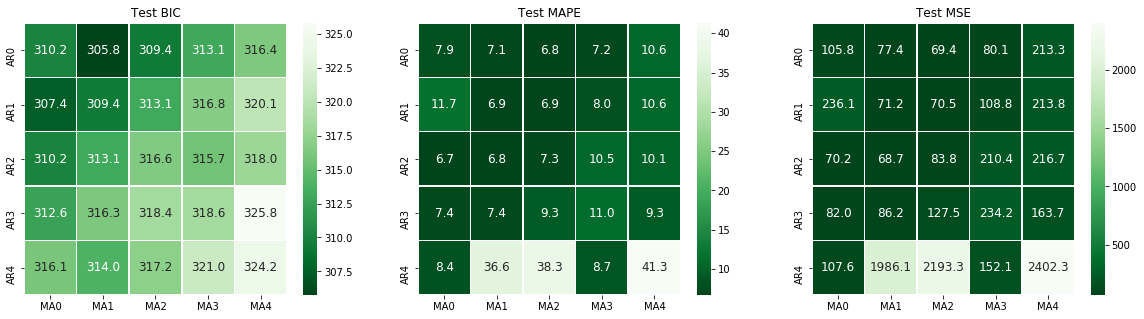

In [283]:
#fig, ax = plt.subplots(figsize=(5, 4))
fig = plt.figure(figsize = (20,5)) # width x height
ax1 = fig.add_subplot(1, 3, 1) # row, column, position
ax2 = fig.add_subplot(1, 3, 2) # row, column, position
ax3 = fig.add_subplot(1, 3, 3) # row, column, position
ax = sns.heatmap(results_bic, mask=results_bic.isnull(), linewidths=.5,  ax=ax1, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax1.set_title('Test BIC');
ax = sns.heatmap(test_MAPE, mask=test_MAPE.isnull(), linewidths=.5,  ax=ax2, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax2.set_title('Test MAPE');
ax = sns.heatmap(test_MSE, mask=test_MSE.isnull(), linewidths=.5,  ax=ax3, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax3.set_title('Test MSE');

# Conclusion on best model looking at Grids of evaluation merics:

Model: 0,1,1

# Retraining GRID Search for Validation to confirm results

In [286]:
train.index.freq = 'MS'
import itertools

p_min = 0
d_min = 1
q_min = 0
p_max = 4
d_max = 1
q_max = 4

# Initialize a DataFrame to store the results
results_bic_val = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )
val_MAPE = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )
val_MSE = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)],
                          )

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        val_MAPE.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        val_MSE.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        
        continue
    
    try:
        model_val = sm.tsa.statespace.SARIMAX(train_test.data, order=(p,d,q), enforce_stationarity=True,
                                            enforce_invertibility=False).fit()
                
        results_val = model_val
        results_bic_val.loc['AR{}'.format(p), 'MA{}'.format(q)] = results_val.bic
        predictions_val = results_val.predict(start=val_start, end=val_end-1, dynamic=False, typ='levels').rename('forecast')
        val_pred = predictions_val.to_frame()
        val1 = pd.merge(val, val_pred, how = 'outer',left_index=True, right_index=True) 
        val_MAPE.loc['AR{}'.format(p), 'MA{}'.format(q)] = get_mape(val1.data, val1.forecast)
        val_MSE.loc['AR{}'.format(p), 'MA{}'.format(q)] = mean_squared_error(val1.data, val1.forecast)
        
    except:
        continue
                                                                              
results_bic_val = results_bic_val[results_bic_val.columns].astype(float)
val_MAPE =val_MAPE[val_MAPE.columns].astype(float)
val_MSE =val_MSE[val_MSE.columns].astype(float)


In [287]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>.output {flex-direction: row;}</style>')

#print("          Val  BIC")
#display(results_bic_val.round(1))
#print("          Val  MAPE")
#display(val_MAPE.round(1))
#print("         Val   MSE")
#display(val_MSE.round(1))

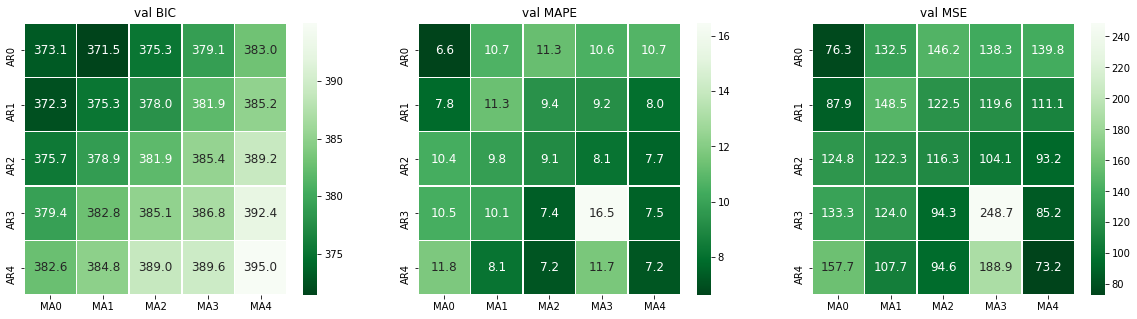

In [288]:
#fig, ax = plt.subplots(figsize=(5, 4))
fig = plt.figure(figsize = (20,5)) # width x height
ax1 = fig.add_subplot(1, 3, 1) # row, column, position
ax2 = fig.add_subplot(1, 3, 2) # row, column, position
ax3 = fig.add_subplot(1, 3, 3) # row, column, position
ax = sns.heatmap(results_bic_val, mask=results_bic_val.isnull(), linewidths=.5,  ax=ax1, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax1.set_title('val BIC');
ax = sns.heatmap(val_MAPE, mask=val_MAPE.isnull(), linewidths=.5,  ax=ax2, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax2.set_title('val MAPE');
ax = sns.heatmap(val_MSE, mask=val_MSE.isnull(), linewidths=.5,  ax=ax3, annot=True, annot_kws={"size": 12}, fmt='.1f', cmap="Greens_r");
ax3.set_title('val MSE');

### Since validation period only has three months with one month having a very high variability, we need to be careful about deducing AR and MA terms here. 

### It is more important to confirm that the model selected using the first training sample is not giving drastically worse results 

### Looking at the output of the retraining on train +test we conclude that it is ok to use the selected model: 0,1,1

In [278]:
val1

,data,forecast
Month,,
2020-04-01,84.0,98.346632
2020-05-01,97.0,97.901716
2020-06-01,99.0,95.410902


# Running the best ARIMA Model post grid search on training set

In [279]:
# fit ARIMA monthly based on helper plots
model2 = sm.tsa.statespace.SARIMAX(train.data, order=(0,1,1), enforce_stationarity=True,
                                            enforce_invertibility=False).fit()
print(model2.summary())
# Obtain predicted values

predictions = model2.predict(start=test_start, end=test_end-1, dynamic=False, typ='levels').rename('forecast')
test_pred = predictions.to_frame()
test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
print("MAPE: ",get_mape(test1.data, test1.forecast))    
print("MSE: ", mean_squared_error(test1.data, test1.forecast))
print("MAE: ", mean_absolute_error(test1.data, test1.forecast))

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   43
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -149.149
Date:                Thu, 03 Sep 2020   AIC                            302.298
Time:                        14:28:24   BIC                            305.773
Sample:                    12-01-2015   HQIC                           303.572
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4838      0.196      2.463      0.014       0.099       0.869
sigma2        70.6761      9.940      7.110      0.000      51.194      90.158
Ljung-Box (Q):                       22.27   Jarque-

# Retraining and FItting the Final Model on train + test set

In [285]:
# fit ARIMA monthly based on helper plots
model2_val = sm.tsa.statespace.SARIMAX(train_test.data, order=(0,1,1), enforce_stationarity=True,
                                            enforce_invertibility=False).fit()
print(model1_val.summary())
# Obtain predicted values

predictions_val = model2_val.predict(start=val_start, end=val_end-1, dynamic=False, typ='levels').rename('forecast')
val_pred = predictions_val.to_frame()
val1 = pd.merge(val, val_pred, how = 'outer',left_index=True, right_index=True) 
print("MAPE: ", get_mape(val1.data, val1.forecast))    
print("MSE: ",  mean_squared_error(val1.data, val1.forecast))
print("MAE: ",  mean_absolute_error(val1.data, val1.forecast))

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   52
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -181.758
Date:                Thu, 03 Sep 2020   AIC                            369.516
Time:                        16:09:43   BIC                            375.312
Sample:                    12-01-2015   HQIC                           371.731
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3491      0.174      2.008      0.045       0.008       0.690
ma.L2         -0.0463      0.183     -0.254      0.800      -0.404       0.312
sigma2        72.7470     14.834      4.904      0.0

# getting fit on training data - keeps a check if the Model is overfitting

In [293]:
# Obtain predicted values on train data
start=1
end=len(train)+len(test)-1
predictions_train = model2.predict(start=start, end=end, dynamic=False, typ='levels').rename('forecast')
predictions_train
train_pred = predictions_train.to_frame()
train1 = pd.merge(train, train_pred, how = 'left',left_index=True, right_index=True)
train1.tail(6).round()

,data,forecast
Month,,
2019-01-01,103.0,101.0
2019-02-01,109.0,104.0
2019-03-01,132.0,111.0
2019-04-01,145.0,142.0
2019-05-01,113.0,146.0
2019-06-01,102.0,97.0


In [291]:
# for error calculation, train data might have nans since the series is differenced. 
train1.isna().sum()
train1.head()
train1 = train1.dropna()

In [292]:
# test metrics

print("Test Model AIC : ", model2.aic, "       Validation Model AIC : ", model2_val.aic)
print("Test Model  : ", model2.bic, "          Validation Model  : ", model2_val.bic)

print("Test MSE: ", mean_squared_error(test1.data, test1.forecast),        "     Val MSE: ", mean_squared_error(val1.data, val1.forecast), "    Train MSE: ", mean_squared_error(train1.data, train1.forecast))
print("Test MAE: ", mean_absolute_error(test1.data, test1.forecast),       "     Val MAE: ", mean_absolute_error(val1.data, val1.forecast), "    Train MAE: ", mean_absolute_error(train1.data, train1.forecast))
print("Test RMSE: ", get_rmse(test1.data, test1.forecast),                  "    Val RMSE: ", get_rmse(val1.data, val1.forecast), "           Train RMSE: ", get_rmse(train1.data, train1.forecast))
print("Test MAPE: ", get_mape(test1.data, test1.forecast),                  "    Val MAPE: ", get_mape(val1.data, val1.forecast), "           Train MAPE: ", get_mape(train1.data, train1.forecast))
print("Test MASE: ", get_mase(test1.data, test1.forecast),                  "    Val MASE: ", get_mase(val1.data, val1.forecast), "                     Train MASE: ", get_mase(train1.data, train1.forecast))

Test Model AIC :  302.29808552174825        Validation Model AIC :  367.611375193716
Test Model  :  305.773424758315           Validation Model  :  371.47502645916467
Test MSE:  2402.2651867441587      Val MSE:  132.45493312086208     Train MSE:  70.68833014659769
Test MAE:  45.29839214105879      Val MAE:  9.393226862939054     Train MAE:  5.656184545831176
Test RMSE:  49.012908368552864     Val RMSE:  11.508906686599822            Train RMSE:  8.40763522915913
Test MAPE:  41.310751218746724     Val MAPE:  10.653798855691274            Train MAPE:  6.513050740976969
Test MASE:  0.8994470631446934     Val MASE:  1.987328304915495                      Train MASE:  0.9761983440149207


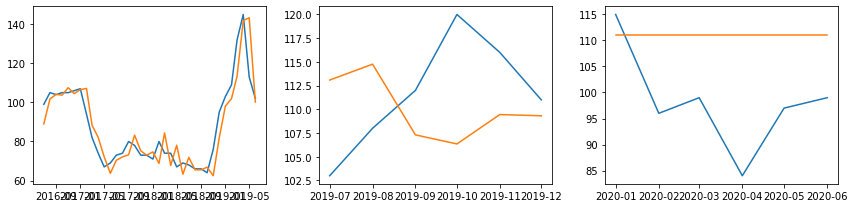

In [116]:

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axes[0].plot(train1[['data','forecast']])
axes[1].plot(test1[['data','forecast']])
axes[2].plot(val1[['data','forecast']])
fig.tight_layout()

In [118]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

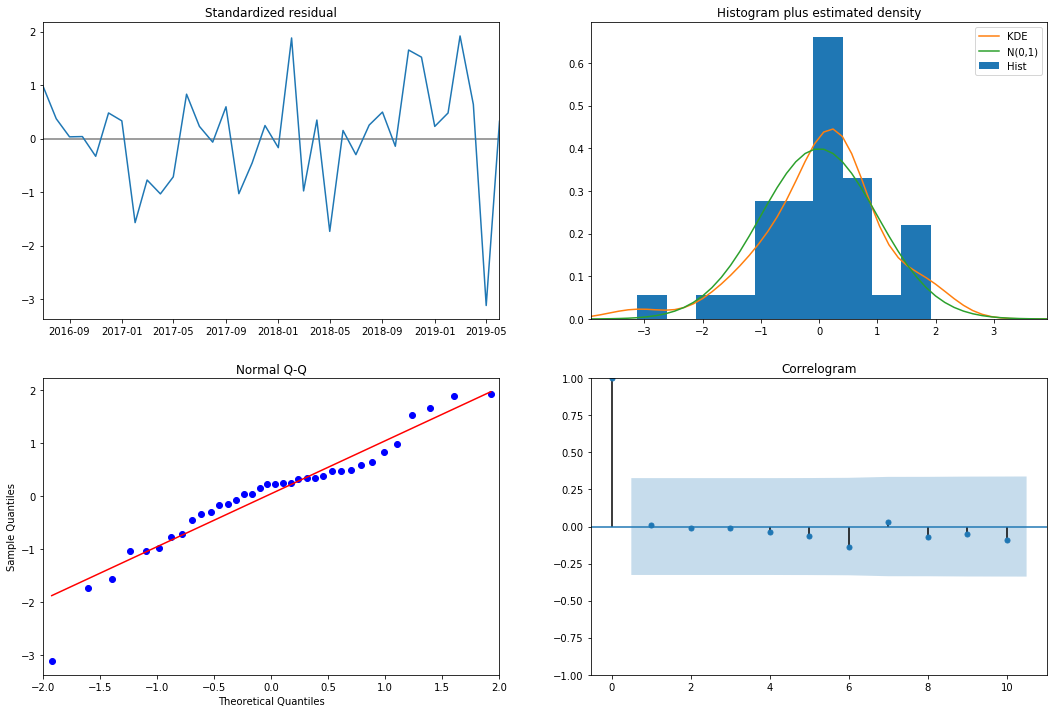

In [119]:
# plot residual diagnostics
model.plot_diagnostics(figsize=(18, 12));

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). However we also we see the high variance towards the start and end of the graph suggesting possible further  improvement

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

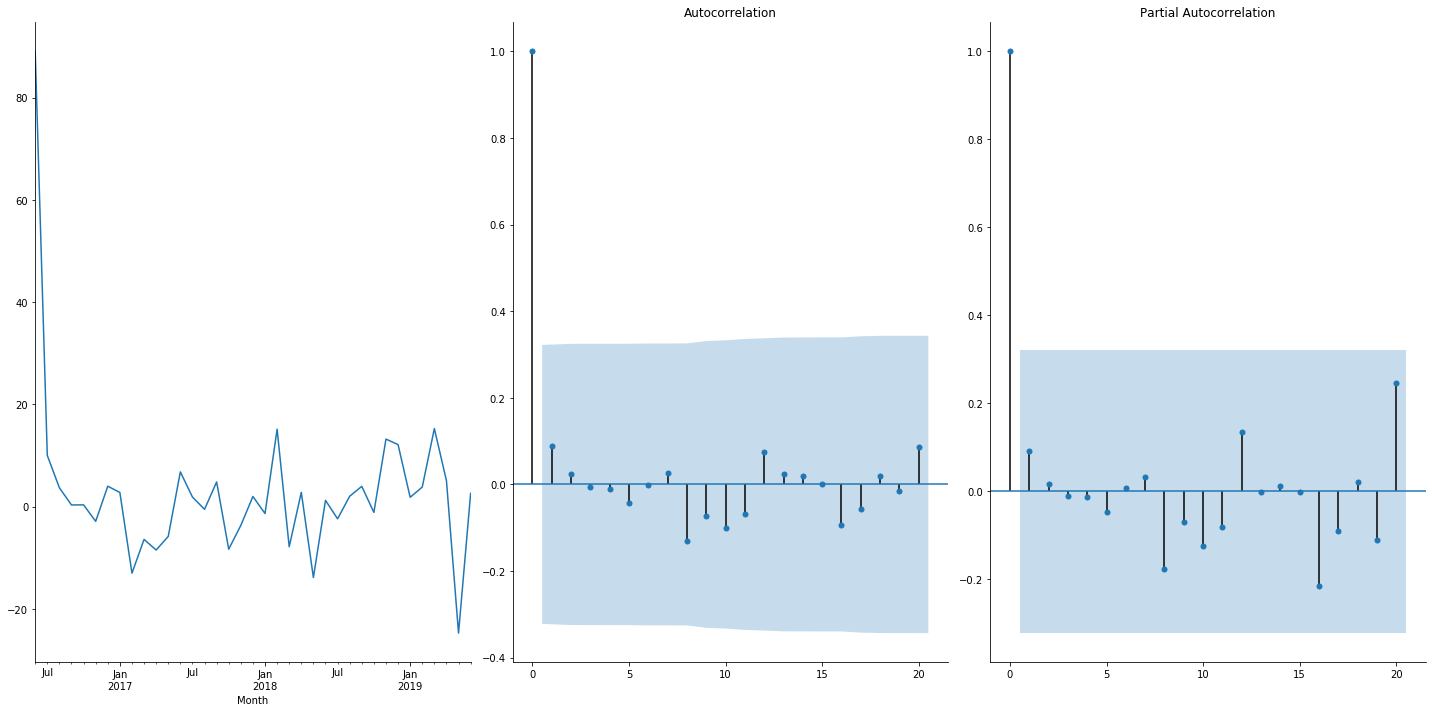

In [118]:
# plot resids
plt.figure(figsize=(20,10))
plots(model.fit().resid, lags=20);